# Statistical Analysis

This script performs a statistical analysis - more specifically the F-test / ANOVA - on the data obtained during simulations throughout the thesis. An F-test can compare the means of various groups and determine if they are equal by looking at their variances. This is done by **checking the variations between the groups compared to the variations within each group**.

In this script, I'll try to prove that each of the given group's results (mean) is significantly different from those of the other populations.

The null hypothesis is that all populations are equal to each other, which we try to reject. A rejection of the null hypothesis implies that at least one distinct population can be made. In other words, if one can reject the null hypothesis, this would mean that there are at least two group means that are statistically significantly different from each other.

If the null hypothesis is correct, than all means of the groups are equal. This would result in a low F-score (close to one).

Based on: 
* https://medium.com/@rrfd/f-tests-and-anovas-examples-with-the-iris-dataset-fe7caa3e21d0
* https://machinelearningmastery.com/statistical-hypothesis-tests-in-python-cheat-sheet/

In [1]:
from sklearn import datasets
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.api as sm 
from statsmodels.formula.api import ols
import statsmodels.stats.multitest as smm
from utils.myutils import load_dict
import seaborn as sns
from scipy.interpolate import make_interp_spline
from scipy.stats import kruskal, mannwhitneyu, ttest_ind, shapiro
from utils.dictionary import *
from scipy.interpolate import interp1d

## Hyperparameters

In [2]:
experiment = 2
use_backup = True
populations = ['NEAT', 'NEAT-GRU', 'NEAT-LSTM', 'NEAT-SRU', 'NEAT-SRU-S']  # NEAT, NEAT-GRU, NEAT-LSTM, NEAT-SRU, NEAT-SRU-S
field = 'finished'  # finished, fitness, or score
generation = 500

## Load in the data

It is assumed that the evaluation of the populations has already finished.

In [3]:
data = []
path = f"population{'_backup' if use_backup else ''}/storage/experiment{experiment}/"
for pop in populations:
    d = load_dict(f"{path}{pop}/evaluation/{field}")
    data.append(d[str(generation)])
df = pd.DataFrame(np.asarray(data).transpose(), columns=populations)
df.head()

,NEAT,NEAT-GRU,NEAT-LSTM,NEAT-SRU,NEAT-SRU-S
0,0.1667,1.0000,0.5000,0.5278,0.4722
1,0.1111,0.4444,0.9167,0.4444,0.0833
2,0.4167,0.7222,0.4722,0.2778,0.5000
3,0.0556,0.9167,0.9444,0.1389,0.3889
4,0.0556,0.8056,0.5278,0.5000,0.2500


In [4]:
df.mean()

NEAT          0.126118
NEAT-GRU      0.758338
NEAT-LSTM     0.700558
NEAT-SRU      0.398888
NEAT-SRU-S    0.297772
dtype: float64

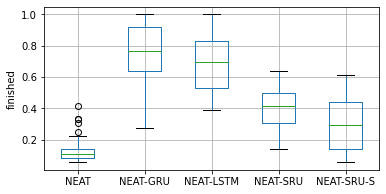

In [5]:
plt.figure(figsize=(6,3))
df.boxplot()
plt.ylabel("finished")
# plt.savefig("temp_boxplot_pure.png", bbox_inches='tight', pad_inches=0.02)
plt.show()
plt.close()

## Handle outliers

In [6]:
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1
IQR

NEAT          0.055600
NEAT-GRU      0.277800
NEAT-LSTM     0.298575
NEAT-SRU      0.194400
NEAT-SRU-S    0.298575
dtype: float64

In [7]:
# No normalisation
# df_n = df

# Normaized dataframes (without any outliers)
df_n = df[(df >= (Q1 - 1.5 * IQR)) & (df <= (Q3 + 1.5 * IQR))]

# Quantile dataframes (only values in the quantiles are kept)
# df_n = df[(df >= Q1) & (df <= Q3)]

df_n.head()

,NEAT,NEAT-GRU,NEAT-LSTM,NEAT-SRU,NEAT-SRU-S
0,0.1667,1.0000,0.5000,0.5278,0.4722
1,0.1111,0.4444,0.9167,0.4444,0.0833
2,NaN,0.7222,0.4722,0.2778,0.5000
3,0.0556,0.9167,0.9444,0.1389,0.3889
4,0.0556,0.8056,0.5278,0.5000,0.2500


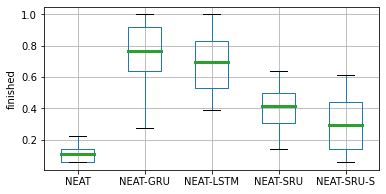

In [8]:
plt.figure(figsize=(6,3))
df_n.boxplot(whis=[0,100],  # Do not define outliers anymore
             medianprops={'linewidth':3})
plt.ylabel("finished")
# plt.savefig("temp_boxplot.png", bbox_inches='tight', pad_inches=0.02)
plt.show()
plt.close()

## Probability distribution

Show how the probabilities for the given metric compare between populations.

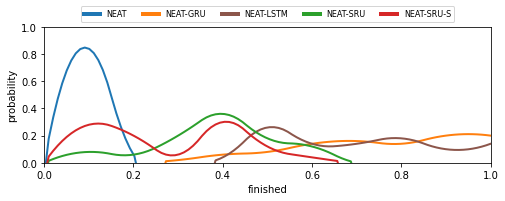

In [9]:
# Put the data into bins
bins = 10
df_r = (df_n*bins).round()/bins

# Show the probabilities of each population
x = [i/bins for i in range(bins+1)]
plt.figure(figsize=(8,2.5))
for pop in populations:
    y = [len(df_r[pop][df_r[pop] == i])/len(df) for i in x]
#     plt.bar(x,y,width=0.05, label=pop, color=COLORS[pop])
#     plt.plot(x,y, label=pop, color=COLORS[pop])
    
    x_new = np.linspace(0,1,100)
    a_BSpline = interp1d(x,y,kind="quadratic")
    y_new = a_BSpline(x_new)
    y_new = [i if i > 0.01 else -0.1 for i in y_new]
    plt.plot(x_new, y_new, linewidth=2, label=pop, color=COLORS[pop])
    
leg = plt.legend(loc='upper center',
                 bbox_to_anchor=(0.5, 1.18),
                 fancybox=True,
                 fontsize=8,
                 ncol=len(populations))
for line in leg.get_lines():
    line.set_linewidth(4.0)
plt.xlim(0,1)
plt.ylim(0,1)
plt.xlabel("finished")
plt.ylabel("probability")
# plt.savefig(f"temp_prob_dist.png", bbox_inches='tight', pad_inches=0.02)
plt.show()
plt.close()

## Test for normality

This part will test if the data we work with is normally distributed. If the distribution is not normal, an F-test should not be used.

In [10]:
# Example of the Shapiro-Wilk Normality Test
for pop in populations:
    stat, p = shapiro(df_n[pop].dropna())
    print('stat=%.3f, p=%.3f' % (stat, p))
    if p > 0.05:
        print(f'{pop} is probably Gaussian (p={p:.5f})')
    else:
        print(f'{pop} is probably not Gaussian (p={p:.5f})')

stat=0.887, p=0.000
NEAT is probably not Gaussian (p=0.00037)
stat=0.938, p=0.011
NEAT-GRU is probably not Gaussian (p=0.01138)
stat=0.922, p=0.003
NEAT-LSTM is probably not Gaussian (p=0.00271)
stat=0.971, p=0.258
NEAT-SRU is probably Gaussian (p=0.25774)
stat=0.939, p=0.013
NEAT-SRU-S is probably not Gaussian (p=0.01268)


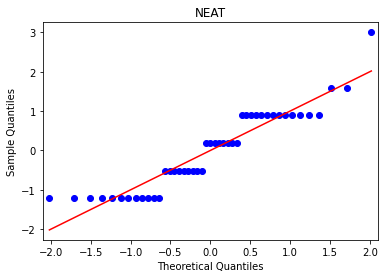

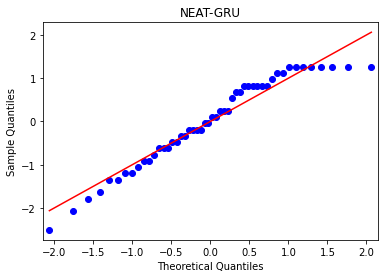

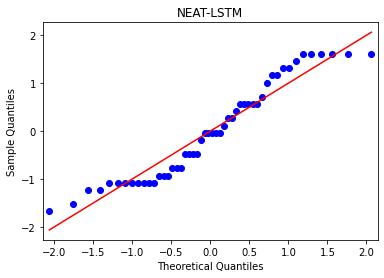

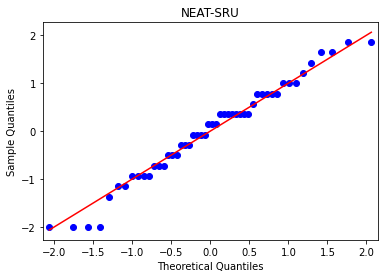

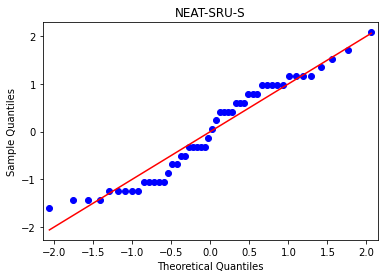

In [11]:
sm.qqplot(df_n['NEAT'].dropna(), line ='s', fit=True) 
plt.title('NEAT')
plt.show() 
sm.qqplot(df_n['NEAT-GRU'].dropna(), line ='s', fit=True) 
plt.title('NEAT-GRU')
plt.show() 
sm.qqplot(df_n['NEAT-LSTM'].dropna(), line ='s', fit=True) 
plt.title('NEAT-LSTM')
plt.show() 
sm.qqplot(df_n['NEAT-SRU'].dropna(), line ='s', fit=True) 
plt.title('NEAT-SRU')
plt.show() 
sm.qqplot(df_n['NEAT-SRU-S'].dropna(), line ='s', fit=True) 
plt.title('NEAT-SRU-S')
plt.show() 

## Statistical Hypothesis

Do further research on the interpretation:
* https://www.socscistatistics.com/tests/mannwhitney/
* https://en.wikipedia.org/wiki/Mann%E2%80%93Whitney_U_test
* https://en.wikipedia.org/wiki/Kruskal%E2%80%93Wallis_one-way_analysis_of_variance

### Mann-Whitney U-test

In [26]:
for i in range(len(populations)):
    pop1 = populations[i]
    for j in range(i+1, len(populations)):
        pop2 = populations[j]
        stat, p = mannwhitneyu(df_n[pop1].dropna(), 
                               df_n[pop2].dropna(), 
                               use_continuity=False, 
                               alternative='two-sided')
        print(f'{pop1} vs {pop2} -  p={p}')

NEAT vs NEAT-GRU -  p=3.9362221291938657e-17
NEAT vs NEAT-LSTM -  p=3.9015164362711783e-17
NEAT vs NEAT-SRU -  p=3.957860858939334e-16
NEAT vs NEAT-SRU-S -  p=1.9316121429900152e-10
NEAT-GRU vs NEAT-LSTM -  p=0.10948937017600198
NEAT-GRU vs NEAT-SRU -  p=1.1367445604048274e-13
NEAT-GRU vs NEAT-SRU-S -  p=1.0464142951357476e-15
NEAT-LSTM vs NEAT-SRU -  p=1.4010047313616951e-12
NEAT-LSTM vs NEAT-SRU-S -  p=9.450830145469254e-16
NEAT-SRU vs NEAT-SRU-S -  p=0.0012795785694641514


In [12]:
stat, p = mannwhitneyu(df_n['NEAT-GRU'].dropna(), df_n['NEAT-LSTM'].dropna(), use_continuity=False, alternative='two-sided')
print(f'stat={stat:.3f}, p={p}')
if p > 0.05:
	print('Probably the same distribution')
else:
	print('Probably different distributions')

stat=1481.500, p=0.10948937017600198
Probably the same distribution


In [13]:
stat, p = mannwhitneyu(df_n['NEAT-GRU'].dropna(), df_n['NEAT-SRU'].dropna(), use_continuity=False, alternative='two-sided')
print(f'stat={stat:.3f}, p={p}')
if p > 0.05:
	print('Probably the same distribution')
else:
	print('Probably different distributions')

stat=2325.500, p=1.1367445604048274e-13
Probably different distributions


In [14]:
stat, p = mannwhitneyu(df_n['NEAT-SRU'].dropna(), df_n['NEAT-SRU-S'].dropna(), use_continuity=False, alternative='two-sided')
print(f'stat={stat:.3f}, p={p}')
if p > 0.05:
	print('Probably the same distribution')
else:
	print('Probably different distributions')

stat=1716.000, p=0.0012795785694641514
Probably different distributions


In [15]:
stat, p = mannwhitneyu(df_n['NEAT-SRU-S'].dropna(), df_n['NEAT'].dropna(), use_continuity=False, alternative='two-sided')
print(f'stat={stat:.3f}, p={p}')
if p > 0.05:
	print('Probably the same distribution')
else:
	print('Probably different distributions')

stat=1973.000, p=1.9316121429900152e-10
Probably different distributions


### Kruskal test

In [16]:
stat, p = kruskal(df_n['NEAT-GRU'].dropna(), df_n['NEAT-LSTM'].dropna())
print(f'stat={stat:.3f}, p={p}')
if p > 0.05:
	print('Probably the same distribution')
else:
	print('Probably different distributions')

stat=2.562, p=0.10948937017600191
Probably the same distribution


In [17]:
stat, p = kruskal(df_n['NEAT-GRU'].dropna(), df_n['NEAT-SRU'].dropna())
print(f'stat={stat:.3f}, p={p}')
if p > 0.05:
	print('Probably the same distribution')
else:
	print('Probably different distributions')

stat=55.115, p=1.1367445604048318e-13
Probably different distributions


In [18]:
stat, p = kruskal(df_n['NEAT-SRU'].dropna(), df_n['NEAT-SRU-S'].dropna())
print(f'stat={stat:.3f}, p={p}')
if p > 0.05:
	print('Probably the same distribution')
else:
	print('Probably different distributions')

stat=10.372, p=0.0012795785694641785
Probably different distributions


In [19]:
stat, p = kruskal(df_n['NEAT-SRU-S'].dropna(), df_n['NEAT'].dropna())
print(f'stat={stat:.3f}, p={p}')
if p > 0.05:
	print('Probably the same distribution')
else:
	print('Probably different distributions')

stat=40.535, p=1.931612142990067e-10
Probably different distributions


## T-test

May only be done if normally distributed!

In [20]:
stat, p = ttest_ind(df_n['NEAT-LSTM'].dropna(), df_n['NEAT-GRU'].dropna())
print(f'stat={stat:.3f}, p={p}')
if p > 0.05:
	print('Probably the same distribution')
else:
	print('Probably different distributions')

stat=-1.514, p=0.13334625693969196
Probably the same distribution


In [21]:
stat, p = ttest_ind(df_n['NEAT-GRU'].dropna(), df_n['NEAT-SRU'].dropna())
print(f'stat={stat:.3f}, p={p}')
if p > 0.05:
	print('Probably the same distribution')
else:
	print('Probably different distributions')

stat=10.883, p=1.485357180274381e-18
Probably different distributions


In [22]:
stat, p = ttest_ind(df_n['NEAT-SRU'].dropna(), df_n['NEAT-SRU-S'].dropna())
print(f'stat={stat:.3f}, p={p}')
if p > 0.05:
	print('Probably the same distribution')
else:
	print('Probably different distributions')

stat=3.568, p=0.0005579081938367526
Probably different distributions


In [23]:
stat, p = ttest_ind(df_n['NEAT-SRU-S'].dropna(), df_n['NEAT'].dropna())
print(f'stat={stat:.3f}, p={p}')
if p > 0.05:
	print('Probably the same distribution')
else:
	print('Probably different distributions')

stat=8.310, p=7.607813355182622e-13
Probably different distributions
